# How to use the VoxelFields class

## What are VoxelFields?
From a high-level perspective, evoxels is organized around two core abstractions: VoxelFields and VoxelGrid. VoxelFields provides a uniform, NumPy-based container for any number of 3D fields on the same regular grid, maximizing interoperability with image I/O libraries (e.g. tifffile, h5py, napari, scikit-image) and visualization tools (PyVista, VTK). VoxelGrid couples these fields to either a PyTorch or JAX backend, offering pre-defined boundary conditions, finite difference stencils and FFT libraries.

It is meant to organize, plot and export multiple fields on the same underlying grid (i.e. same shape, origin, spacing and grid convention).


## Getting started
Import the evoxels library together with numpy

In [1]:
import evoxels as evo
import numpy as np

Create a voxel fields object and explore some of its properties

In [2]:
Nx, Ny, Nz = [20, 10, 5]
vf = evo.VoxelFields((Nx, Ny, Nz), domain_size=(Nx, Ny, Nz))
print("VoxelFields object is now defined as")
print(f" - grid with {vf.Nx} x {vf.Ny} x {vf.Nz} points,")
print(f" - defined with {vf.convention} grid convention.")
print(f" - Physical domain size {vf.domain_size}")
print(f" - and the resulting grid spacing {vf.spacing}")
print(f" - First grid point (origin) is located at {vf.origin}")
print(f" - Float precision of data is set to {vf.precision}")

VoxelFields object is now defined as
 - grid with 20 x 10 x 5 points,
 - defined with cell_center grid convention.
 - Physical domain size (20, 10, 5)
 - and the resulting grid spacing (1.0, 1.0, 1.0)
 - First grid point (origin) is located at (0.5, 0.5, 0.5)
 - Float precision of data is set to float32


The ``cell_center`` grid convention assumes that field values 'live' at the center of each voxel (denoted by red dots in the figure below). Fluxes between two voxels are computed at so-called staggered field positions, i.e.
- x fluxes live on sides staggered to the right (blue)
- y fluxes live staggered to the top (green)

<img src="../voxelsss-grid.png" width="300px">

Initialize field with random noise

In [3]:
noise = 0.5 + 0.1*np.random.rand(Nx, Ny, Nz)
noise[0,:,:] = 0.1
vf.add_field("c", noise)

Explore plotting utilities of voxelFields class

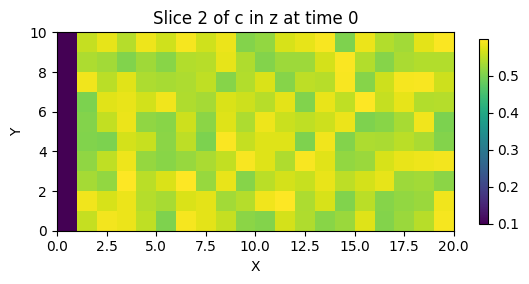

In [4]:
%matplotlib inline
vf.plot_slice('c', 2, direction='z', time='0')

Interactive plotting to scroll through slices

In [5]:
# %matplotlib widget
# vf.plot_field_interactive("c", direction='x', colormap='turbo')

We can now plug the initial concentration field into the Periodic Cahn-Hilliard solver

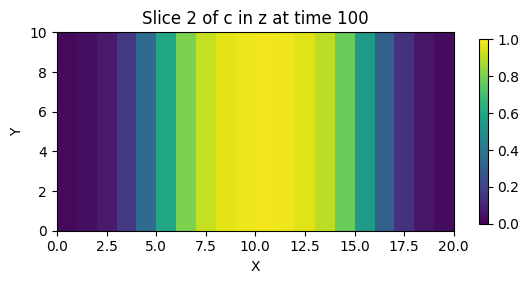

Wall time: 7.4976 s after 100 iterations (0.075 s/iter)
GPU-RAM (nvidia-smi)  current: 117 MB (117 MB max)
GPU-RAM (torch)       current: 8.14 MB (8.16 MB max, 22.00 MB reserved)


In [6]:
%matplotlib inline
vf.add_field("c", noise)

end_time = 100
dt = 1
evo.run_cahn_hilliard_solver(
        vf, 'c', 'torch', jit='False', device='cuda',
        time_increment=dt, frames=10, max_iters=int(end_time/dt),
        verbose='plot', vtk_out=False, plot_bounds=(0,1))

Export the final concentration field after solve to vtk

In [7]:
vf.export_to_vtk(filename='test.vtk')

## Staggered grid positions

For some FFT solvers with mixed boundary conditions it is preferable to work with a staggered grid i.e. the node positions are shifted in a specific direction. To compute tortuosity, we utilize Dirichlet BCs in x-direction while the y- and z-direction are governed by zero-flux or periodic boundary conditions.

The VoxelFields object has the grid convention as an attribute which can be set to ``staggered_x``. Note that there are now nodes located at the left and right boundary i.e. the grid spacing equals ``dx = Lx/(Nx-1)`` as exemplified below.

The field values are now stored at the blue positions.

<img src="../voxelsss-grid.png" width="300px">

In [8]:
Nx, Ny, Nz = [21, 10, 5]
vf = evo.VoxelFields((Nx, Ny, Nz), domain_size=(Nx-1, Ny, Nz), convention='staggered_x')
print("VoxelFields object is now defined as")
print(f" - grid with {vf.Nx} x {vf.Ny} x {vf.Nz} points,")
print(f" - defined with {vf.convention} grid convention.")
print(f" - Physical domain size {vf.domain_size}")
print(f" - and the resulting grid spacing {vf.spacing}")
print(f" - First grid point (origin) is located at {vf.origin}")
print(f" - Float precision of data is set to {vf.precision}")

VoxelFields object is now defined as
 - grid with 21 x 10 x 5 points,
 - defined with staggered_x grid convention.
 - Physical domain size (20, 10, 5)
 - and the resulting grid spacing (1.0, 1.0, 1.0)
 - First grid point (origin) is located at (0, 0.5, 0.5)
 - Float precision of data is set to float32


As this staggered grid positions are rather unusual, there is no 100% consistent way to visualize these fields. In a general sense, our data is still zonal data and will therefore be visualized with ``imshow`` in python and be exported using ``cell_data`` for the ``.vtk`` format. However, to highlight the difference, the origin is now shifted such that the first datapoints correlate with x=0 and the last with x=Lx.

In [9]:
noise = 0.5 + 0.1*np.random.rand(Nx, Ny, Nz)
noise[0,:,:] = 0.1
vf.add_field("c", noise)

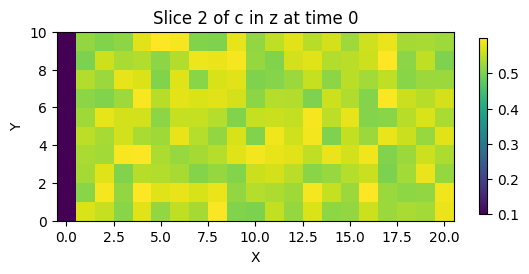

In [10]:
%matplotlib inline
vf.plot_slice('c', 2, direction='z', time='0')